# Lighthouse Indicium

# 0.0 Planejamento da Solução (IOT)

## Input (Entrada)

**1. Problema de Negócio**
* Precificar os carros do cliente o mais próximo aos valores do mercado

**2. Conjunto de Dados**
* Base de dados de um marketplace de compra e venda

## Output (Saída)

**1. Predição dos preços dos carros**
* Lista com: id_carro | preço
    
**2. Relatório das variáveis (features)**
* Análise das principais estatísticas descritivas com visualização

**3. Análise Exploratória dos Dados (EDA)**
* 3 hipóteses de negócio
* Perguntas feitas pelo cliente
    - Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?
    - Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?
    - Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?

## Tasks (Tarefas)

**1. Predição dos preços dos carros**
* Desenvolver modelo a partir da base de dados para predição dos preços dos carros.
    
**2. Relatório das variáveis (features)**
* Análise do comportamento de cada variável (média, mediana, distribuição, etc)

**3. Análise Exploratória dos Dados (EDA)**
* 3 hipóteses de negócio
    - Mapa mental para brainstorm e criação de hipóteses
* Perguntas feitas pelo cliente
    - Qual o melhor estado cadastrado na base de dados para se vender um carro de marca popular e por quê?
        - Quais as principais condições para o estado ser melhor? Preço?
    - Qual o melhor estado para se comprar uma picape com transmissão automática e por quê?
         - Quais as principais condições do veículo/estado para ser melhor? Quilometragem, preço, revisão?
    - Qual o melhor estado para se comprar carros que ainda estejam dentro da garantia de fábrica e por quê?
        - Análise dos carros com garantia de fábrica por estado.

# 0.0 IMPORTS

In [51]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display  import HTML

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor

from feature_engine.encoding import CountFrequencyEncoder

## 0.1 Helper Functions

In [2]:
def descriptive_analysis(num_attributes):
    # Tendência Central - média, mediana
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # Concate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
    
    return m


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option('display.expand_frame_repr', False )
    pd.set_option('display.float_format', '{:.4f}'.format)
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [4]:
df_raw = pd.read_csv('../data/raw/cars_train.csv', encoding='utf16', sep='\t')

In [5]:
df_raw.sample(3)

,id,num_fotos,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio,num_portas,tipo,blindado,cor,tipo_vendedor,cidade_vendedor,estado_vendedor,anunciante,entrega_delivery,troca,elegivel_revisao,dono_aceita_troca,veiculo_único_dono,revisoes_concessionaria,ipva_pago,veiculo_licenciado,garantia_de_fábrica,revisoes_dentro_agenda,veiculo_alienado,preco
11263,95034029123121936496087361992391792947,8.0000,MERCEDES-BENZ,C 350,3.5 SPORT SEDAN V6 GASOLINA 4P AUTOMÁTICO,2006,2012.0000,128671.0000,Automática,4,Hatchback,N,Preto,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,Aceita troca,NaN,NaN,IPVA pago,Licenciado,NaN,NaN,NaN,57795.8318
17169,139788973341859569682097145040401935279,8.0000,CHERY,ARRIZO 6,1.5 VVT TURBO iFLEX GSX CVT,2021,2021.0000,11198.0000,CVT,4,Utilitário esportivo,N,Branco,PF,Prudentópolis,Minas Gerais (MG),Pessoa Física,False,False,False,Aceita troca,Único dono,NaN,IPVA pago,Licenciado,Garantia de fábrica,NaN,NaN,147523.4620
3183,107433681389105710364187096979341204086,8.0000,VOLKSWAGEN,T-CROSS,1.0 200 TSI TOTAL FLEX COMFORTLINE AUTOMÁTICO,2018,2018.0000,19021.0000,Automática,4,Sedã,N,Cinza,PF,São Paulo,São Paulo (SP),Pessoa Física,False,False,False,NaN,Único dono,Todas as revisões feitas pela concessionária,IPVA pago,Licenciado,Garantia de fábrica,Todas as revisões feitas pela agenda do carro,NaN,113129.3728


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

Reduzindo nome das colunas e retirando acentos para facilitar aplicações futuras.

In [7]:
df1 = df1.rename(columns = {'ano_de_fabricacao': 'ano_fabricacao',
                            'entrega_delivery': 'delivery',
                            'dono_aceita_troca': 'aceita_troca',
                            'veiculo_único_dono': 'unico_dono',
                            'ipva_pago': 'ipva',
                            'veiculo_licenciado': 'licenciado',
                            'garantia_de_fábrica': 'garantia_fabrica',
                            'revisoes_dentro_agenda': 'revisoes_agenda',
                            'veiculo_alienado': 'alienado'})

## 1.2 Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 29584
Number of Cols: 29


## 1.3 Data Types

Análise inicial dos tipos de cada feature.

In [9]:
df1.dtypes

id                          object
num_fotos                  float64
marca                       object
modelo                      object
versao                      object
ano_fabricacao               int64
ano_modelo                 float64
hodometro                  float64
cambio                      object
num_portas                   int64
tipo                        object
blindado                    object
cor                         object
tipo_vendedor               object
cidade_vendedor             object
estado_vendedor             object
anunciante                  object
delivery                      bool
troca                         bool
elegivel_revisao              bool
aceita_troca                object
unico_dono                  object
revisoes_concessionaria     object
ipva                        object
licenciado                  object
garantia_fabrica            object
revisoes_agenda             object
alienado                   float64
preco               

## 1.4 Check NA

Conferindo valores nulos em cada feature.

In [10]:
df1.isna().sum()

id                             0
num_fotos                    177
marca                          0
modelo                         0
versao                         0
ano_fabricacao                 0
ano_modelo                     0
hodometro                      0
cambio                         0
num_portas                     0
tipo                           0
blindado                       0
cor                            0
tipo_vendedor                  0
cidade_vendedor                0
estado_vendedor                0
anunciante                     0
delivery                       0
troca                          0
elegivel_revisao               0
aceita_troca                7662
unico_dono                 19161
revisoes_concessionaria    20412
ipva                        9925
licenciado                 13678
garantia_fabrica           25219
revisoes_agenda            23674
alienado                   29584
preco                          0
dtype: int64

## 1.5 Descriptive Statistical

In [11]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1 Numerical Attributes

In [12]:
descriptive_analysis(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,8.0000,21.0000,13.0000,10.3238,NaN,3.4873,1.0014,-0.6510
1,ano_fabricacao,1985.0000,2022.0000,37.0000,2016.7586,2018.0000,4.0624,-2.4938,9.1891
2,ano_modelo,1997.0000,2023.0000,26.0000,2017.8090,2018.0000,2.6739,-0.4986,-0.5225
3,hodometro,100.0000,390065.0000,389965.0000,58430.5921,57434.0000,32561.2190,0.5909,1.1946
4,num_portas,2.0000,4.0000,2.0000,3.9407,4.0000,0.3384,-5.5450,28.7976
5,alienado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,preco,9869.9506,1359812.8923,1349942.9417,133023.8799,114355.7970,81661.4920,2.1490,10.9749


### 1.5.2 Categorical Attributes

In [13]:
cat_attributes.apply(lambda x: x.unique().shape[0])

id                         29584
marca                         40
modelo                       457
versao                      1916
cambio                         7
tipo                           7
blindado                       2
cor                            7
tipo_vendedor                  2
cidade_vendedor              575
estado_vendedor               25
anunciante                     4
delivery                       2
troca                          2
elegivel_revisao               1
aceita_troca                   2
unico_dono                     2
revisoes_concessionaria        2
ipva                           2
licenciado                     2
garantia_fabrica               2
revisoes_agenda                2
dtype: int64

#### Marca

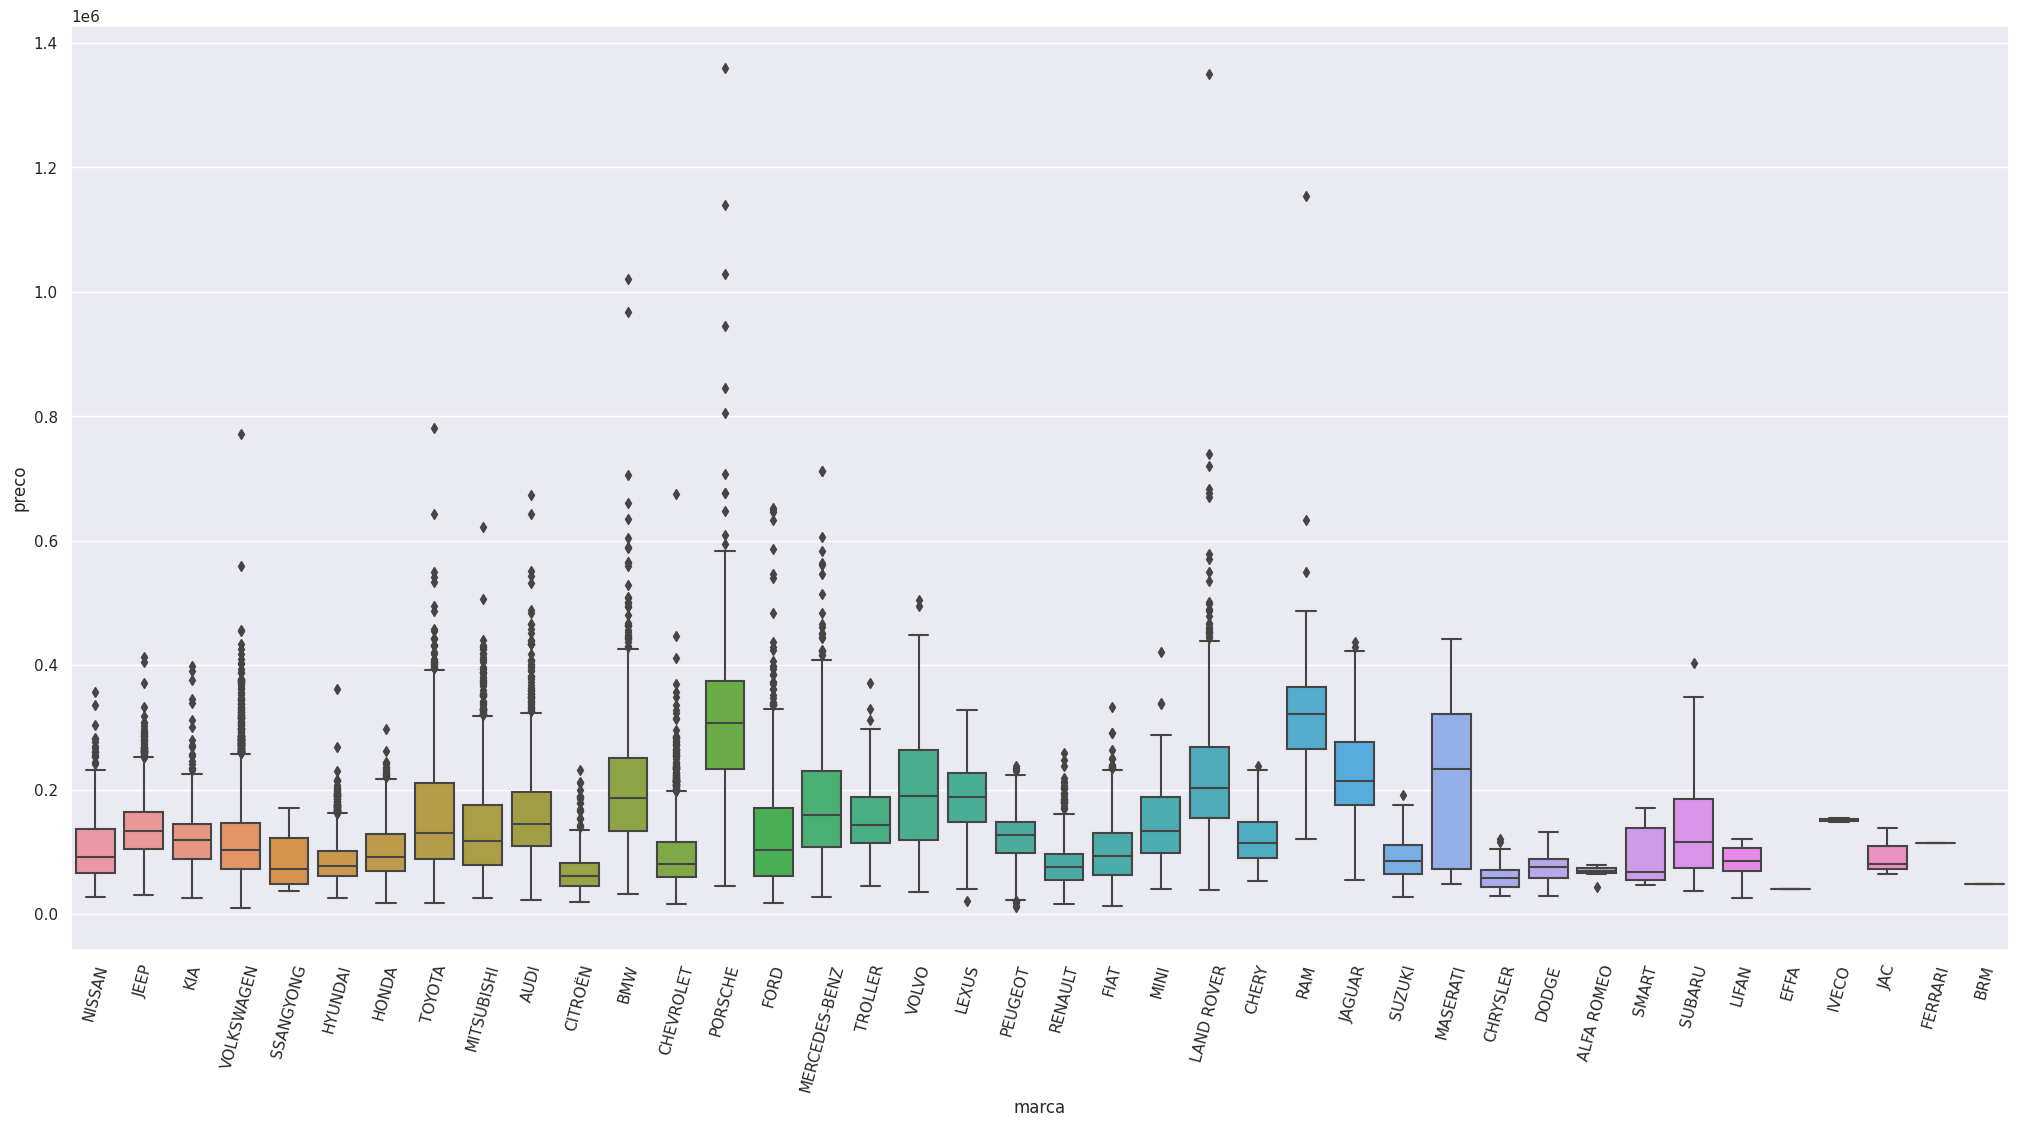

In [16]:
sns.boxplot(x='marca', y='preco', data=df1)
plt.xticks(rotation=75);

#### Cambio

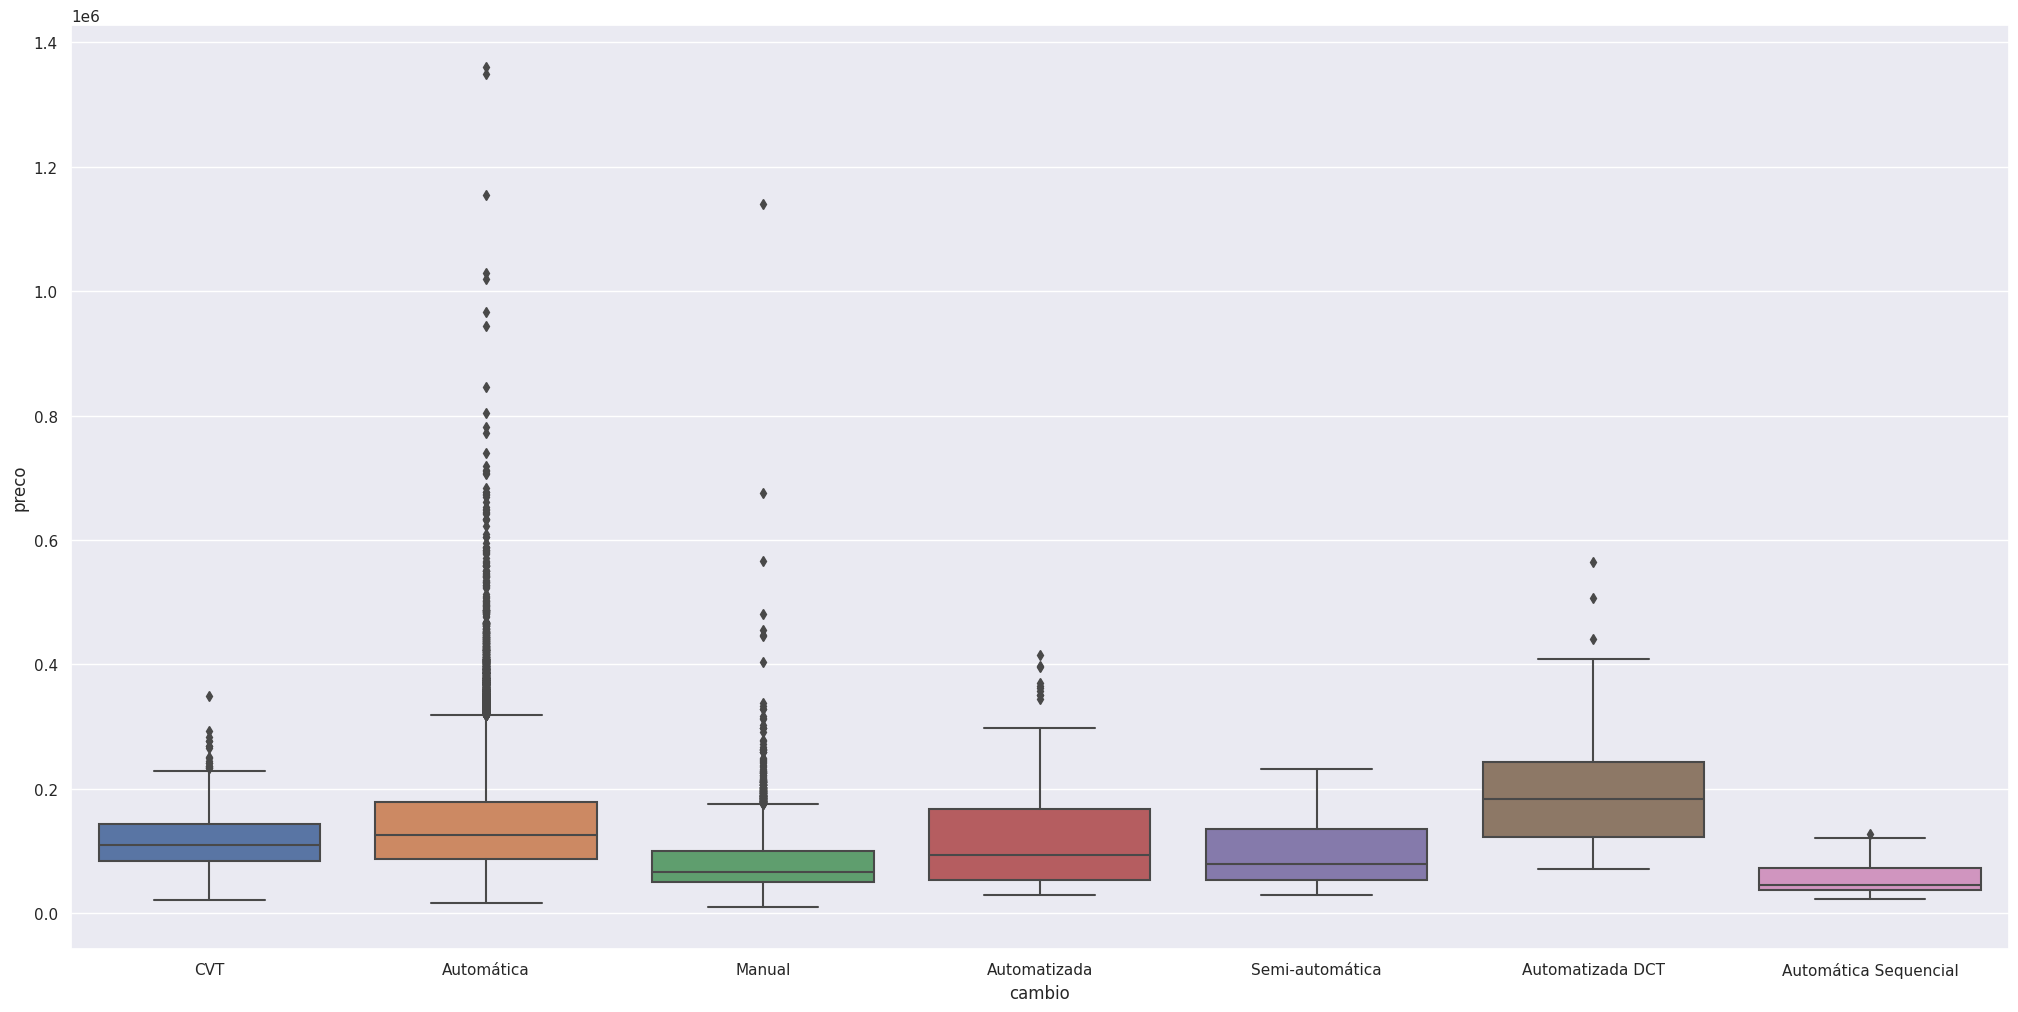

In [24]:
sns.boxplot(x='cambio', y='preco', data=df1);

#### Tipo

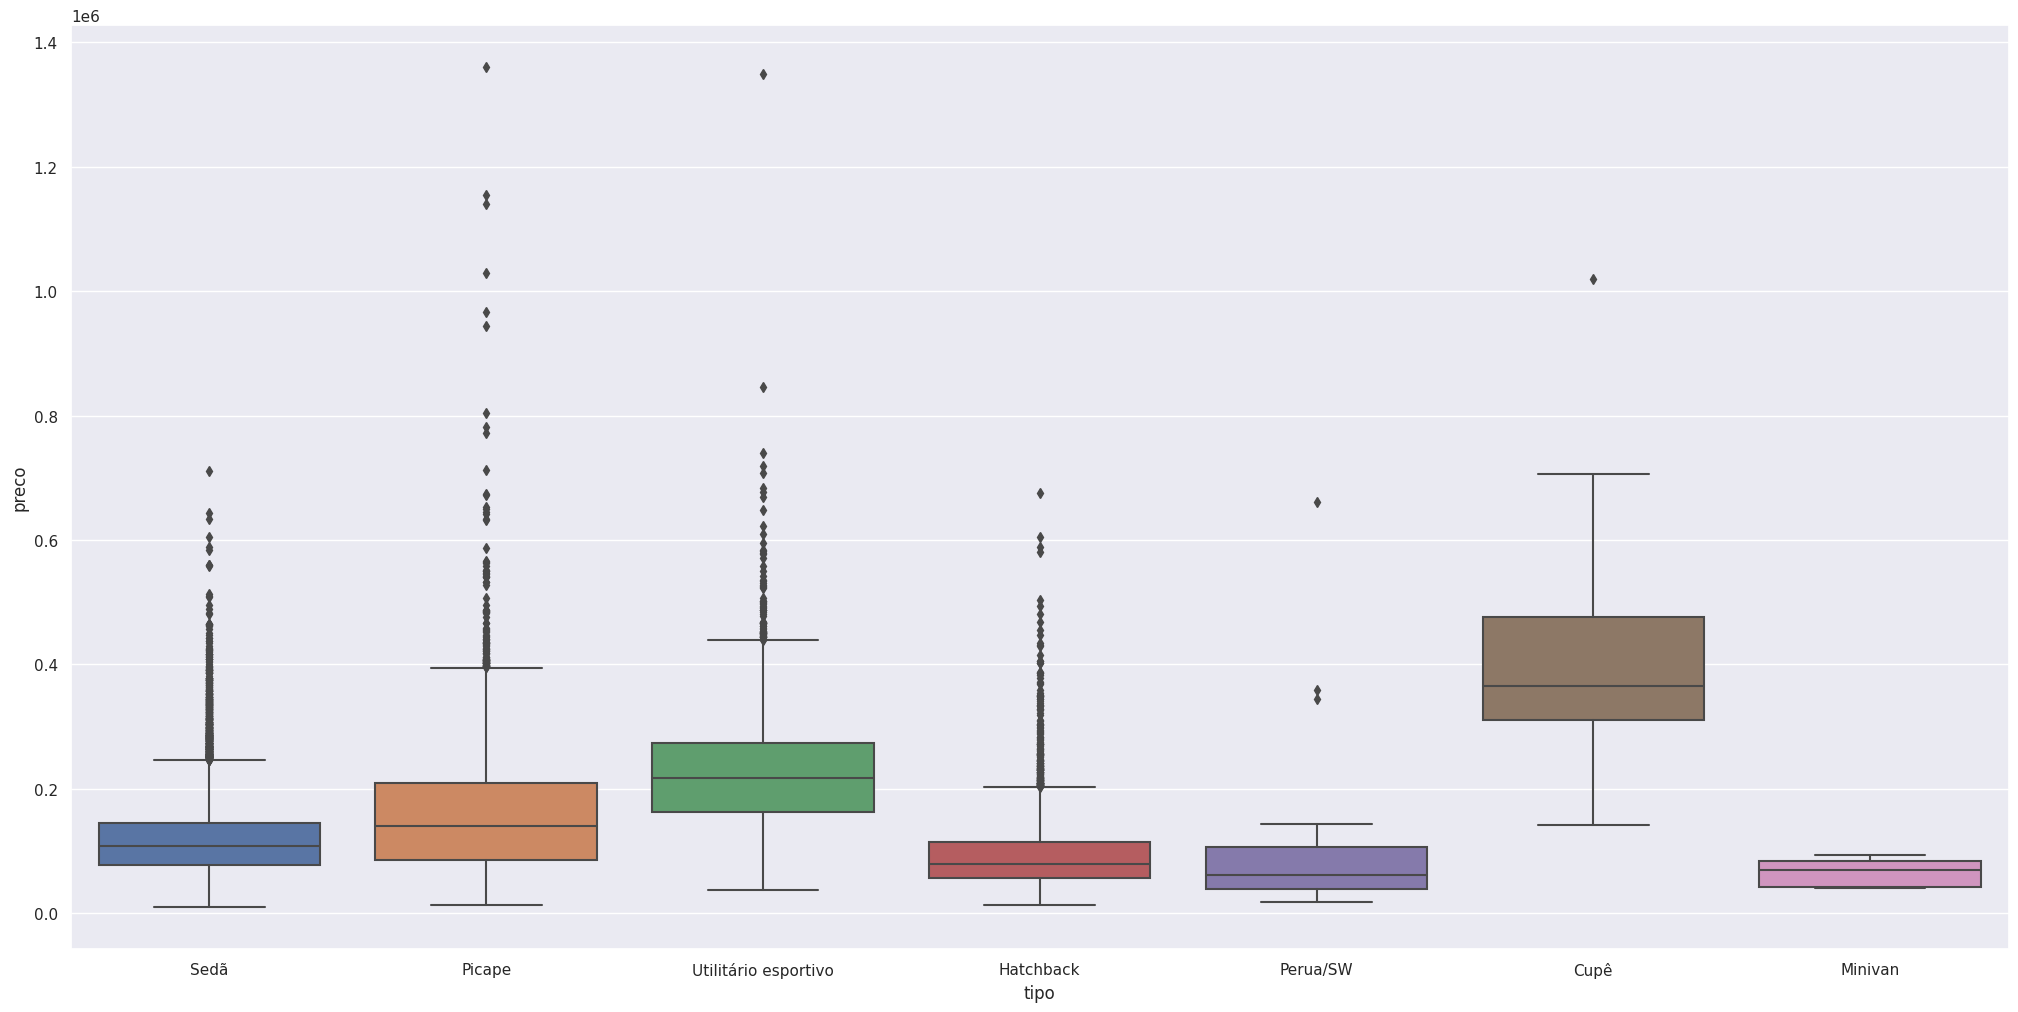

In [23]:
sns.boxplot(x='tipo', y='preco', data=df1);

#### Cor

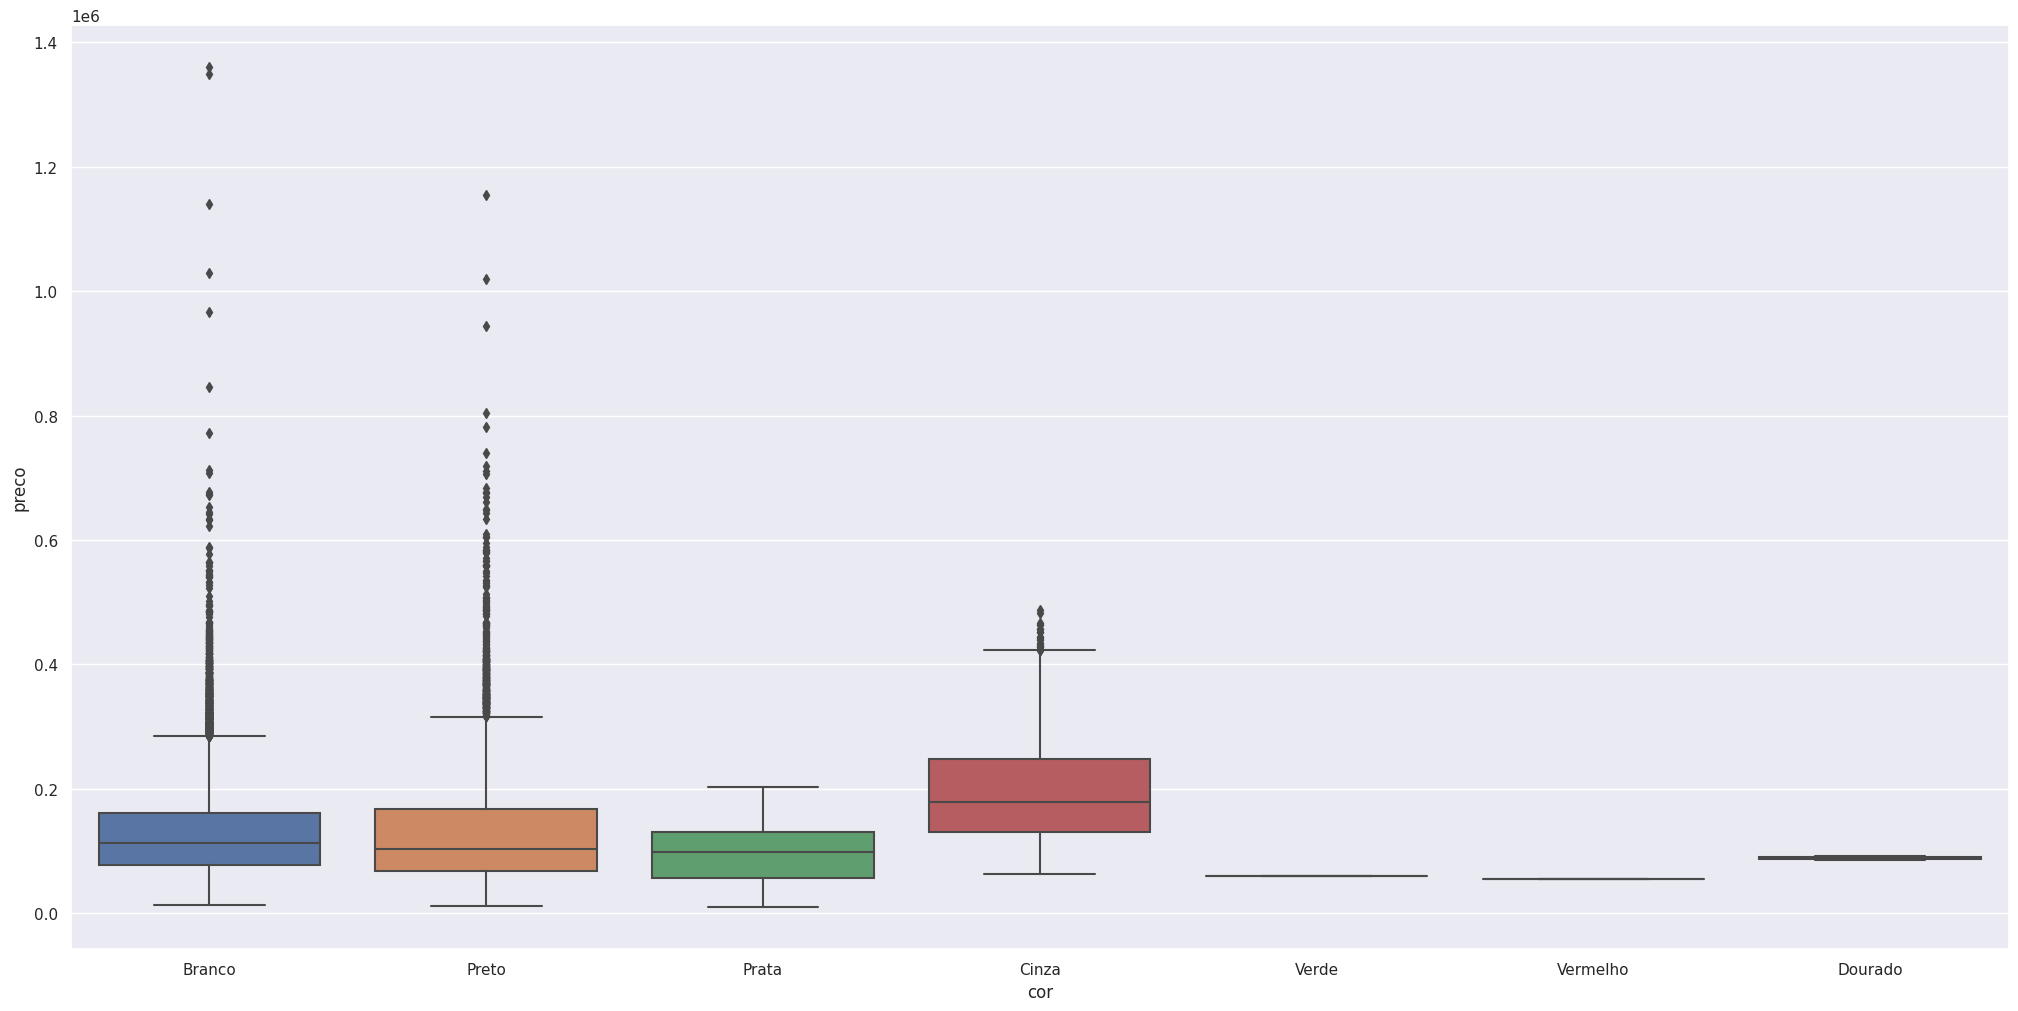

In [26]:
sns.boxplot(x='cor', y='preco', data=df1);

#### Estado

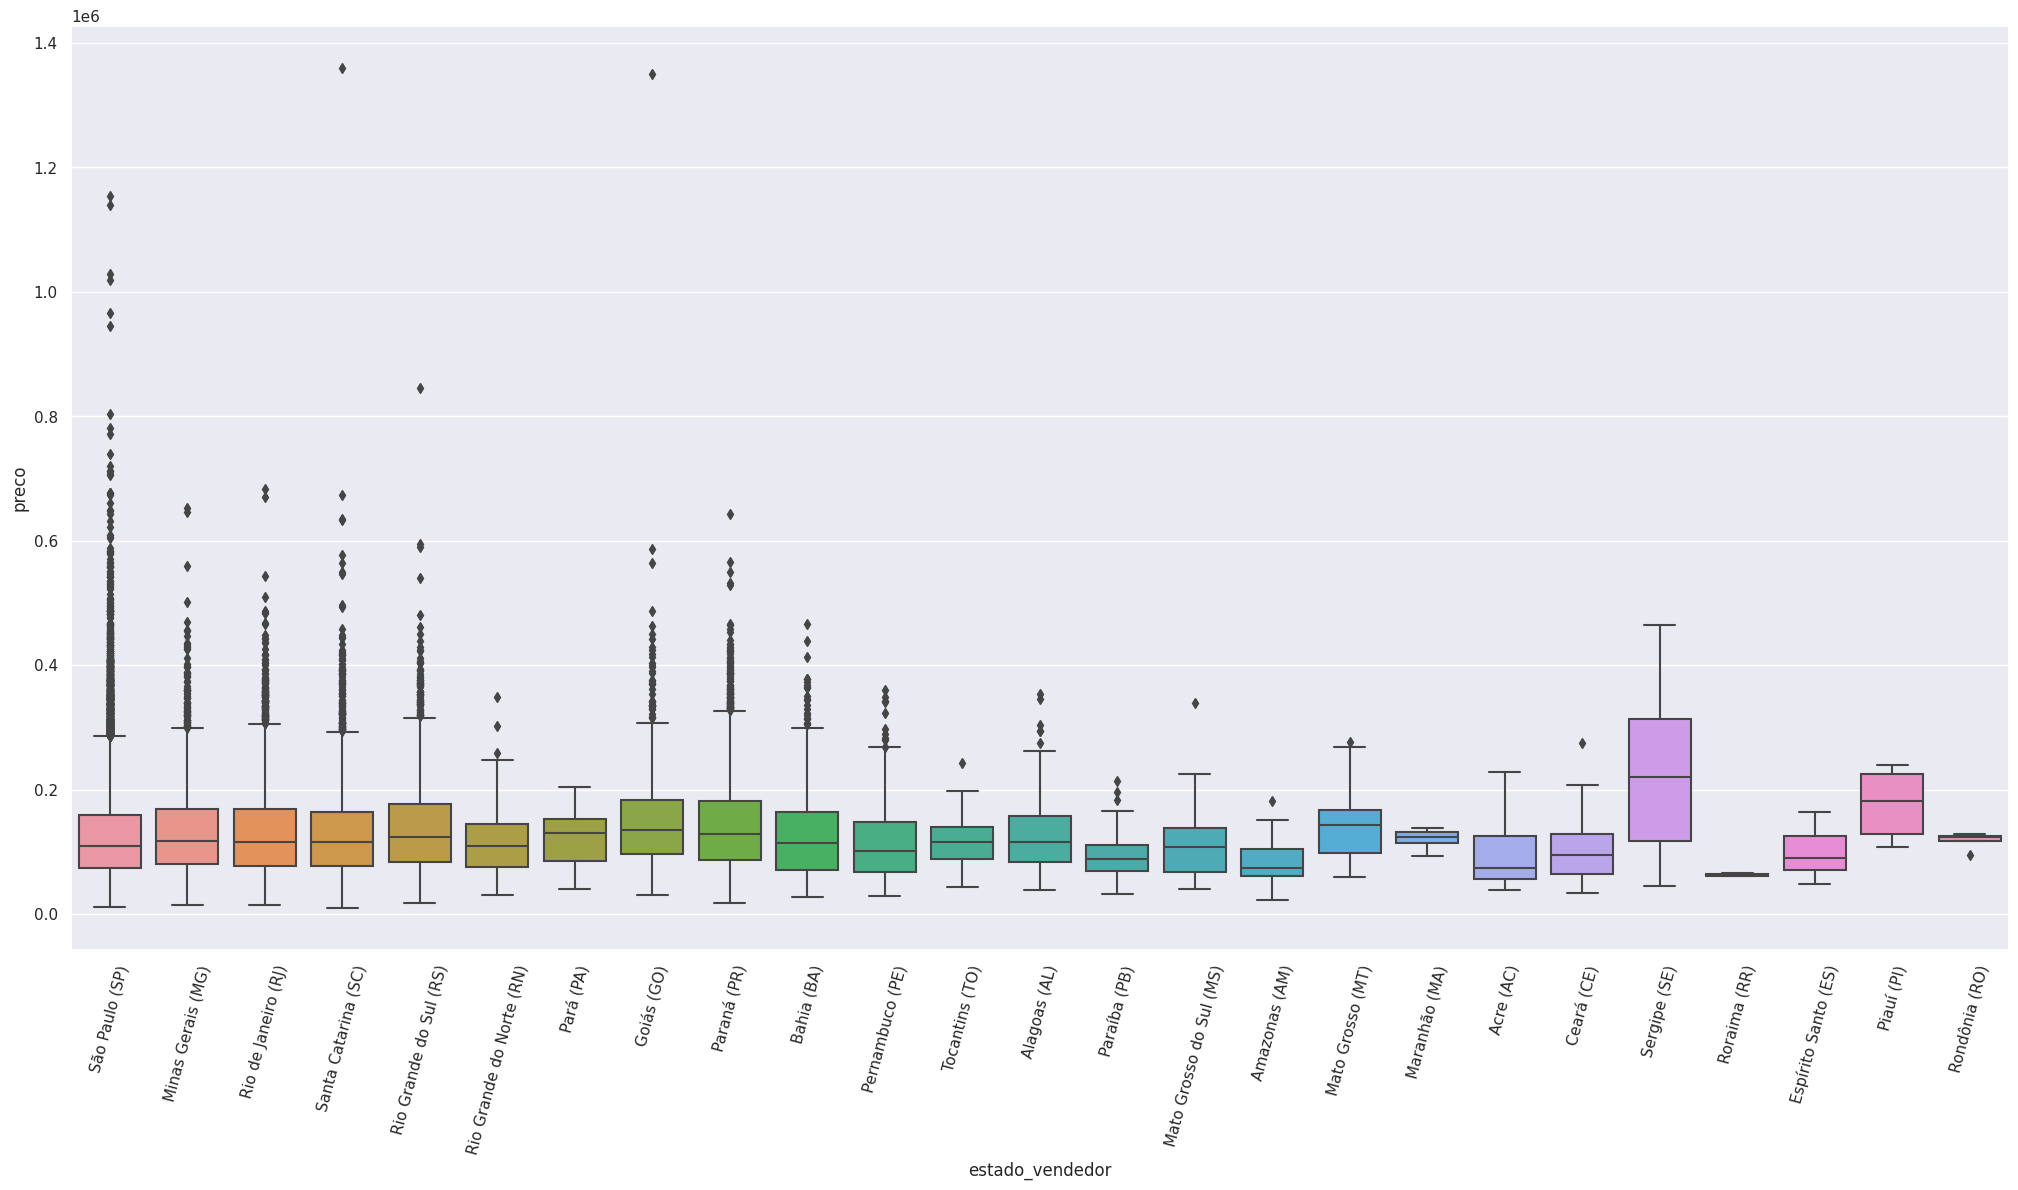

In [28]:
sns.boxplot(x='estado_vendedor', y='preco', data=df1)
plt.xticks(rotation=75);

#### Anunciante

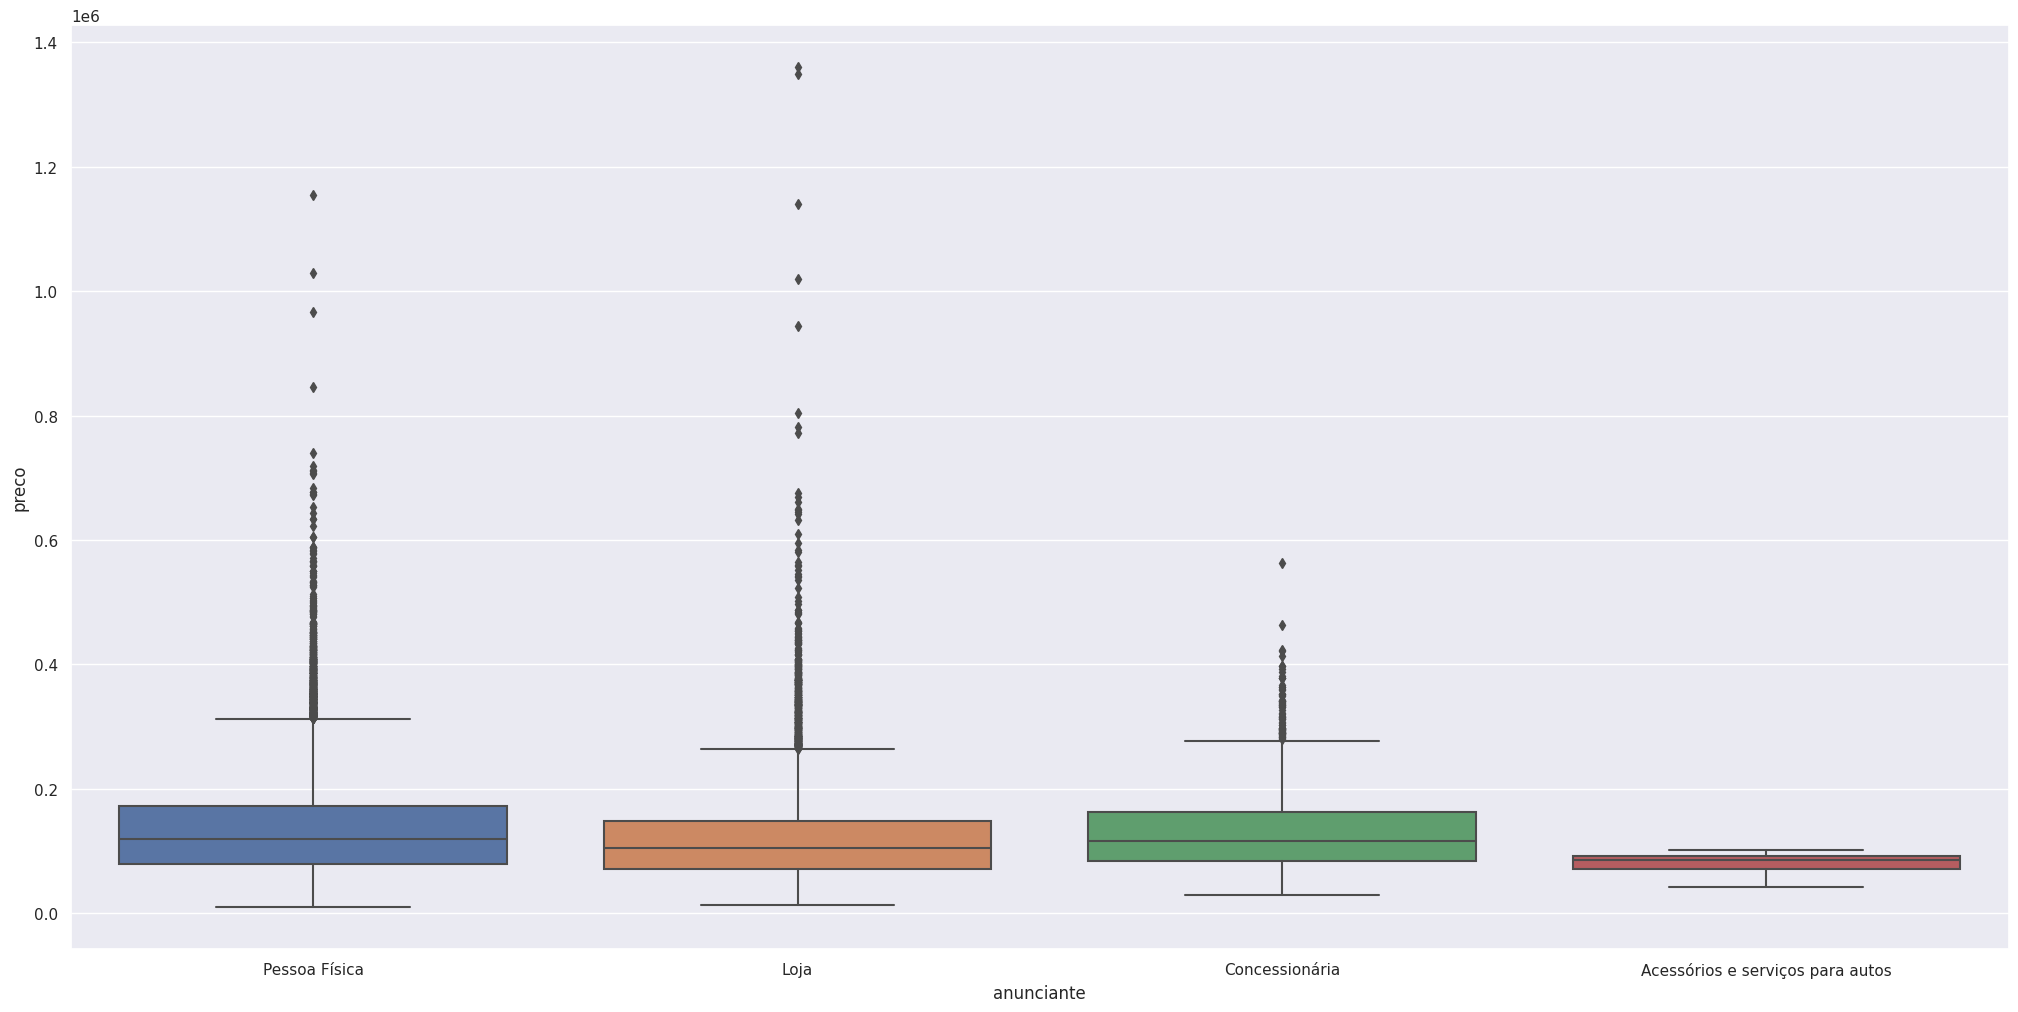

In [38]:
sns.boxplot(x='anunciante', y='preco', data=df1);

#### Outros

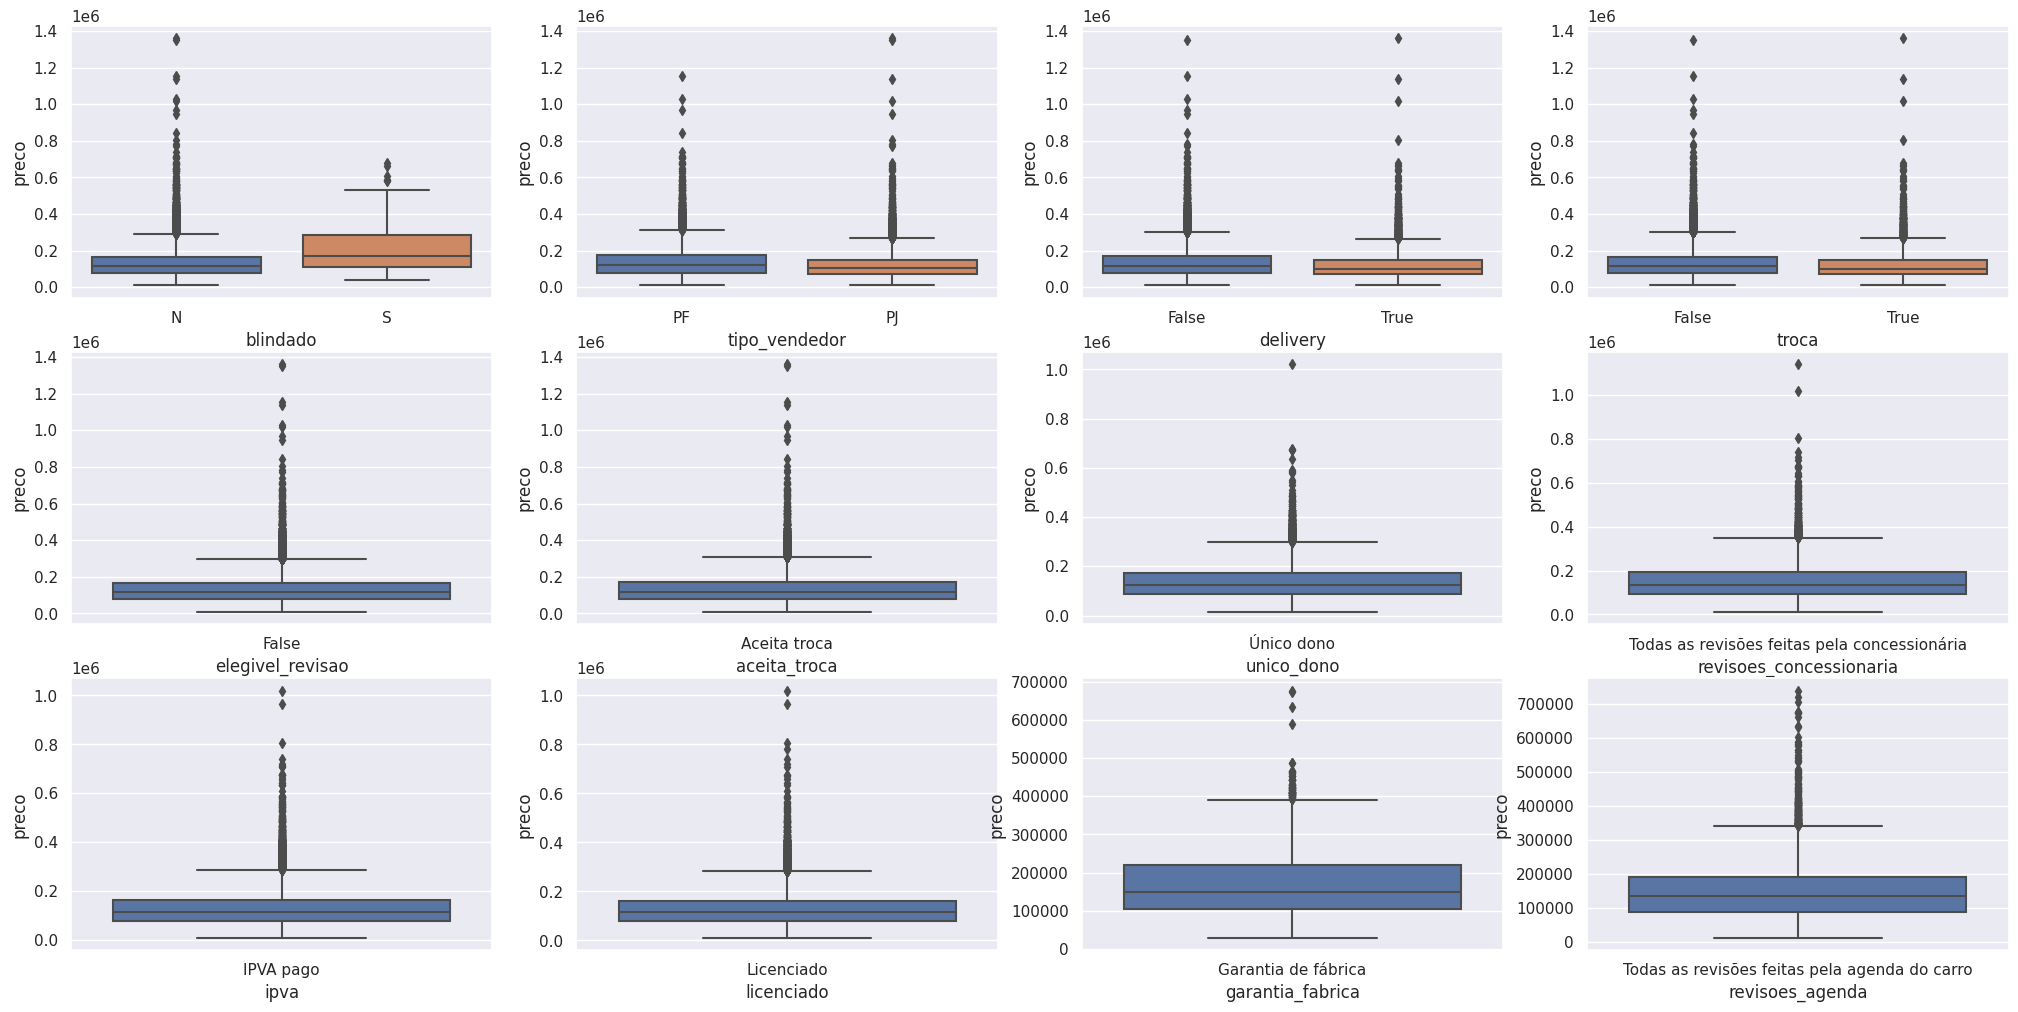

In [44]:
list_features = ['blindado', 'tipo_vendedor', 'delivery', 'troca', 'elegivel_revisao', 'aceita_troca',
                 'unico_dono', 'revisoes_concessionaria', 'ipva', 'licenciado', 'garantia_fabrica', 'revisoes_agenda']

for index, feature in enumerate(list_features, start=1):
    plt.subplot(3, 4, index)
    sns.boxplot(x=feature, y='preco', data=df1)

# 2.0 FEATURE ENGINEERING

In [104]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses de Características

**1.** Carros com mais portas são mais caros.

**2.** Carros com motores flex são mais caros.

**3.** Carros sem alterações são mais caros.

**4.** Carros com ano de fabricação mais recentes são mais caros.

**5.** Carros com modelos mais recentes são mais caros.

**6.** Carros brancos são mais caros.

**7.** Carros com maiores cilindradas são mais caros.

**8.** Carros com acessórios são mais caros.

### 2.2.2 Hipóteses de Tempo e Local

**1.** O preço dos veículos é maior no Sudeste.

**2.** O preço dos caros é maior no começo do ano.

**3.** Caros vendidos por lojas são mais caros.

### 2.2.3 Hipóteses de Situação do veículo

**1.** Carros com donos únicos são mais caros.

**2.** Carros com mais quilometragem são mais baratos.

**3.** Carros com documentação vencida são mais baratos.

**4.** Carros com acidentes previos são mais baratos.

**5.** Carros sem manutenção são mais baratos.

## 2.4 Feature Engineering

In [105]:
# número de fotos
# Número de fotos faltantes serão considerados 0
df2['num_fotos'].fillna(0, inplace=True)

# extraindo features com regular expression

df2['identificacao'] = df2['marca'] + '-' + df2['modelo']

# cilindradas
df2['cilindradas'] = df2['versao'].str.extract(r"(\d\.\d)")

# combustivel
df2['combustivel'] = df2['versao'].apply(lambda x: 'gasolina' if re.search('GASOLINA', x)
                                         else 'flex' if re.search('FLEX', x)
                                         else 'diesel' if re.search('DIESEL', x)
                                         else 'etanol' if re.search('ETANOL', x)
                                         else 'outro')

# Preenchendo valores faltantes
# Todos os valores faltantes foram considerados False
# troca
df2['aceita_troca'] = df2['aceita_troca'].apply(lambda x: False if pd.isna(x) else True)

# unico dono
df2['unico_dono'] = df2['unico_dono'].apply(lambda x: False if pd.isna(x) else True)

# revisoes concessionaria
df2['revisoes_concessionaria'] = df2['revisoes_concessionaria'].apply(lambda x: False if pd.isna(x) else True)

# ipva
df2['ipva'] = df2['ipva'].apply(lambda x: False if pd.isna(x) else True)

# licenciado
df2['licenciado'] = df2['licenciado'].apply(lambda x: False if pd.isna(x) else True)

# garantia de fabrica
df2['garantia_fabrica'] = df2['garantia_fabrica'].apply(lambda x: False if pd.isna(x) else True)

# revisoes agenda
df2['revisoes_agenda'] = df2['revisoes_agenda'].apply(lambda x: False if pd.isna(x) else True)

### 2.4.1 Conferindo Cidades e Estados

Há no dataset cidades com estados incorretos, para isso é necessário verificar se as cidades realmente pertencem ao estado informado.

In [106]:
df2.loc[9802]

id                         100782370360602513820631340414980252519
num_fotos                                                   8.0000
marca                                                         FIAT
modelo                                                        TORO
versao                        2.0 16V TURBO DIESEL VOLCANO 4WD AT9
ano_fabricacao                                                2019
ano_modelo                                               2019.0000
hodometro                                               45523.0000
cambio                                                  Automática
num_portas                                                       4
tipo                                                        Picape
blindado                                                         N
cor                                                         Branco
tipo_vendedor                                                   PF
cidade_vendedor                                       Bady Bas

Utilizando uma API podemos verificar as informações para cada combinação.

In [74]:
from __future__ import print_function
import time
import cloudmersive_validate_api_client
from cloudmersive_validate_api_client.rest import ApiException
from pprint import pprint

In [75]:
# Configure API key authorization: Apikey
configuration = cloudmersive_validate_api_client.Configuration()
configuration.api_key['Apikey'] = 'c2f350df-b1ad-44c0-b1a0-b1ce2ca2f01f'

In [108]:
# create an instance of the API class
api_instance = cloudmersive_validate_api_client.AddressApi(cloudmersive_validate_api_client.ApiClient(configuration))
input = cloudmersive_validate_api_client.ValidateCityRequest() # ValidateCityRequest | Input parse request

try:
    # Validate a City and State/Province combination, get location information about it
    api_response = api_instance.address_validate_city({"City": "Bady Bassitt",
                                                       "StateOrProvince": "São Paulo (SP)",
                                                       "CountryFullName": "Brazil"})
    pprint(api_response)
except ApiException as e:
    print("Exception when calling AddressApi->address_validate_city: %s\n" % e)

{'city': 'Bady Bassitt',
 'latitude': -20.9178969,
 'longitude': -49.4517911,
 'state_or_province': 'SP',
 'valid_city': True}


*A cidade Bady Bassitt não fica no estado do Rio de Janeiro.*

Por questões de tempo e limite de requisições permitidas na API, essa informação não será corrigida e análisada agora.

# 3.0 FILTRAGEM DE VARIÁVEIS

Ignorada no ciclo inicial.

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

Ignorada no ciclo inicial.

# 5.0 DATA PREPARATION

In [122]:
df5 = df1.copy()

## 5.1 Separação de Treino e Teste

In [144]:
X = df5[df5.columns.drop(['id', 'preco'])]

# Transformacao logaritma na feature target
y = np.log1p(df5['preco'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

## 5.2 Preparação dos dados de treino

In [145]:
# numero de fotos
X_train['num_fotos'].fillna(0, inplace=True)
mms_fotos = MinMaxScaler()
X_train['num_fotos'] = mms_fotos.fit_transform(X_train[['num_fotos']].values)

#marca, modelo, cor, cidade_vendedor, estado_vendedor
encoder = CountFrequencyEncoder(encoding_method='frequency',
                                variables=['marca', 'cor', 'modelo', 'cidade_vendedor', 'estado_vendedor'],
                                unseen='encode')
# fit the encoder
encoder.fit(X_train)

# transform
X_train = encoder.transform(X_train)

# ano_fabricacao
mms_fabricacao = MinMaxScaler()
X_train['ano_fabricacao'] = mms_fabricacao.fit_transform(X_train[['ano_fabricacao']].values)

# ano_modelo
mms_modelo = MinMaxScaler()
X_train['ano_modelo'] = mms_modelo.fit_transform(X_train[['ano_modelo']].values)

# hodometro
mms_hodometro = MinMaxScaler()
X_train['hodometro'] = mms_hodometro.fit_transform(X_train[['hodometro']].values)

# cambio
le_cambio = LabelEncoder()
X_train['cambio'] = le_cambio.fit_transform(X_train['cambio'])

# numero de portas
mms_portas = MinMaxScaler()
X_train['num_portas'] = mms_portas.fit_transform(X_train[['num_portas']].values)

# tipo
le_tipo = LabelEncoder()
X_train['tipo'] = le_tipo.fit_transform(X_train[['tipo']])

# blindado
le_blindado = LabelEncoder()
X_train['blindado'] = le_blindado.fit_transform(X_train[['blindado']].values)

# tipo_vendedor
le_vendedor = LabelEncoder()
X_train['tipo_vendedor'] = le_vendedor.fit_transform(X_train['tipo_vendedor'])

# anunciante
le_anunciante = LabelEncoder()
X_train['anunciante'] = le_anunciante.fit_transform(X_train['anunciante'])

# entrega_delivery
X_train.delivery = X_train.delivery.replace({True: 1, False:0})

# troca
X_train.troca = X_train.troca.replace({True: 1, False:0})

# elegivel revisao
X_train.elegivel_revisao = X_train.elegivel_revisao.replace({True: 1, False:0})

# aceita troca
X_train['aceita_troca'] = X_train['aceita_troca'].apply(lambda x: 0 if pd.isna(x) else 1)

# unico dono
X_train['unico_dono'] = X_train['unico_dono'].apply(lambda x: 0 if pd.isna(x) else 1)

# revisoes concessionaria
X_train['revisoes_concessionaria'] = X_train['aceita_troca'].apply(lambda x: 0 if pd.isna(x) else 1)

# ipva
X_train['ipva'] = X_train['ipva'].apply(lambda x: 0 if pd.isna(x) else 1)

# licenciado
X_train['licenciado'] = X_train['licenciado'].apply(lambda x: 0 if pd.isna(x) else 1)

# garantia_fabrica
X_train['garantia_fabrica'] = X_train['garantia_fabrica'].apply(lambda x: 0 if pd.isna(x) else 1)

# revisoes_agenda
X_train['revisoes_agenda'] = X_train['revisoes_agenda'].apply(lambda x: 0 if pd.isna(x) else 1)

/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 5.4 Preparação dos dados de teste

In [146]:
# numero de fotos
X_test['num_fotos'].fillna(0, inplace=True)
X_test['num_fotos'] = mms_fotos.transform(X_test[['num_fotos']].values)

#marca, modelo, cor, cidade_vendedor, estado_vendedor
# transform
X_test = encoder.transform(X_test)

# ano_fabricacao
X_test['ano_fabricacao'] = mms_fabricacao.transform(X_test[['ano_fabricacao']].values)

# ano_modelo
X_test['ano_modelo'] = mms_modelo.transform(X_test[['ano_modelo']].values)

# hodometro
X_test['hodometro'] = mms_hodometro.transform(X_test[['hodometro']].values)

# cambio
X_test['cambio'] = le_cambio.transform(X_test['cambio'])

# numero de portas
X_test['num_portas'] = mms_portas.transform(X_test[['num_portas']].values)

# tipo
X_test['tipo'] = le_tipo.transform(X_test[['tipo']])

# blindado
X_test['blindado'] = le_blindado.transform(X_test[['blindado']].values)

# tipo_vendedor
X_test['tipo_vendedor'] = le_vendedor.transform(X_test['tipo_vendedor'])

# anunciante
X_test['anunciante'] = le_anunciante.transform(X_test['anunciante'])

# entrega_delivery
X_test.delivery = X_test.delivery.replace({True: 1, False:0})

# troca
X_test.troca = X_test.troca.replace({True: 1, False:0})

# elegivel revisao
X_test.elegivel_revisao = X_test.elegivel_revisao.replace({True: 1, False:0})

# aceita troca
X_test['aceita_troca'] = X_test['aceita_troca'].apply(lambda x: 0 if pd.isna(x) else 1)

# unico dono
X_test['unico_dono'] = X_test['unico_dono'].apply(lambda x: 0 if pd.isna(x) else 1)

# revisoes concessionaria
X_test['revisoes_concessionaria'] = X_test['aceita_troca'].apply(lambda x: 0 if pd.isna(x) else 1)

# ipva
X_test['ipva'] = X_test['ipva'].apply(lambda x: 0 if pd.isna(x) else 1)

# licenciado
X_test['licenciado'] = X_test['licenciado'].apply(lambda x: 0 if pd.isna(x) else 1)

# garantia_fabrica
X_test['garantia_fabrica'] = X_test['garantia_fabrica'].apply(lambda x: 0 if pd.isna(x) else 1)

# revisoes_agenda
X_test['revisoes_agenda'] = X_test['revisoes_agenda'].apply(lambda x: 0 if pd.isna(x) else 1)

/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/matheus/.pyenv/versions/3.10.7/envs/ge_ml/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 6.0 FEATURE SELECTION

Para análise inicial, as features versao e alienado foram desconsideradas.

In [147]:
X_train = X_train[X_train.columns.drop(['versao', 'alienado'])]
X_test = X_test[X_test.columns.drop(['versao', 'alienado'])]

# 7.0 MACHINE LEARNING

## 7.1 Average Model

In [117]:
aux1 = df5[['marca', 'modelo']]
aux1['identificacao'] = aux1['marca'] + ' ' + aux1['modelo']
aux1['preco'] = y

X_mean_train, X_mean_test = train_test_split(aux1, test_size=0.25, random_state=7)

aux2 = X_mean_train[['identificacao',
             'preco']].groupby('identificacao').mean().reset_index().rename(columns={'preco': 'predictions'})

# merge
X_mean_test = pd.merge(X_mean_test, aux2, how='left', on='identificacao')

# Preenchendo valores faltantes para carros nao encontrados
X_mean_test['predictions'].fillna(aux2['predictions'].mean(), inplace=True)

# performance
baseline_result = ml_error('Average Model', np.expm1(X_mean_test['preco']), np.expm1(X_mean_test['predictions']))
baseline_result

/tmp/ipykernel_6867/2587287083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['identificacao'] = aux1['marca'] + ' ' + aux1['modelo']
/tmp/ipykernel_6867/2587287083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['preco'] = y


,Model Name,MAE,MAPE,RMSE
0,Average Model,37392.6966,0.3119,55391.4515


## 7.2 Linear Regression Model

In [148]:
# model
lr = LinearRegression().fit(X_train, y_train)

# prediction
yhat_lr = lr.predict(X_test)

# performace
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,44563.8407,0.3698,65561.9199


## 7.3 Linear Regression Regularized Model - Lasso

In [154]:
# model
lrr = Lasso(alpha=0.005).fit(X_train, y_train)

# prediction
yhat_lrr = lrr.predict(X_test)

# performace
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,46984.5877,0.3833,70314.2234


## 7.4 Random Forest Regressor

In [174]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=7).fit(X_train, y_train)

# prediction
yhat_rf = rf.predict(X_test)

# performace
rf_result = ml_error('Random Forest Regression - Lasso', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression - Lasso,28013.2247,0.2300,43431.5836


## 7.5 XGBoost Regressor

In [163]:
# model
model_xgb = xgb.XGBRegressor(n_estimators=100,
                             random_state=7).fit(X_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,27551.6606,0.2237,41999.3463


## 7.6 LightGBM Regressor

In [172]:
# model
model_lgbm = lgbm.LGBMRegressor(n_estimators=300).fit(X_train, y_train)

# prediction
yhat_lgbm = model_lgbm.predict(X_test)

# performance
lgbm_result = ml_error('LightGBM Regressor', np.expm1(y_test), np.expm1(yhat_lgbm))
lgbm_result

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 22188, number of used features: 23
[LightGBM] [Info] Start training from score 11.637541


,Model Name,MAE,MAPE,RMSE
0,LightGBM Regressor,27053.6408,0.2190,41845.9696


## 7.7 Compare Model's Performace

In [175]:
modelling_result_cv = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result, lgbm_result])
modelling_result_cv.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,LightGBM Regressor,27053.6408,0.2190,41845.9696
0,XGBoost Regressor,27551.6606,0.2237,41999.3463
0,Random Forest Regression - Lasso,28013.2247,0.2300,43431.5836
0,Average Model,37392.6966,0.3119,55391.4515
0,Linear Regression,44563.8407,0.3698,65561.9199
0,Linear Regression - Lasso,46984.5877,0.3833,70314.2234


# 8.0 HYPERPARAMETER FINE TUNING

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

# 10.0 DEPLOY MODEL